This data was provided by the New York Times. Their data includes daily number of total cases at a county level. 

The data is downloadable at: https://github.com/nytimes/covid-19-data

The data is presented by NYT journalists at: https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html

The purpose of this notebook is to make it clear when the rate of exponential growth is changing or when counties/areas begin to level off from exponenitial growth. In the first plot (the log-log plot), this can be seen as a decrease in the slope of the line representing the number of cases, as a lower slope indicates a decrease in the time it takes for cases to double. 

The second plot is a phase-space plot, a parametric plot where the y axis is the daily new case rate and the x-axis is the total number of cases. For this plot, changes out of exponentiality can be seen as a vertical drop off of the diagonal line. When areas are on the diagonal line, their new cases are linearly proportional to their existing cases, i.e., pure exponential growth. A drop towards the x-axis means that the number of new cases is lower than expected for pure exponential growth (Good!). Countries such as China and South Korea which have seen drastic decreases in the number of new cases (i.e. clear success stories) exhibit this steep drop off of the diagonal line. 

Credit for the second plot idea goes to Aatish Bhatia: https://www.realclearscience.com/video/2020/03/28/how_to_tell_if_were_beating_covid-19.html



In [1]:
import pandas as pd

countydata = pd.read_csv("us-counties.csv",parse_dates=["date"])
print("Most recent date: %s" % max(countydata["date"]))
countydata.head()

Most recent date: 2020-04-01 00:00:00


,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates
from matplotlib.dates import DateFormatter
from datetime import date, timedelta
from matplotlib.ticker import ScalarFormatter
import datetime
import numpy as np 

#To-do: 
# implement ways to have counties in different specified states (needed for counties whose names occur in two+ states)
# implement ways to make a regression line for each county 

def regressionline(days,dates,count,color="lightgrey"):
    dates = dates[count>0]
    count = count[count>0]
    #fits a regression line for length of time defined by variable "days"
    #dates and count are the index and the column "cases" of the csv file (properly aggregated or just for 1 county)
    
    todaydiff = [(max(dates) - day)/np.timedelta64(1,'D') for day in dates] # number of days before today for creating mask
    mask = np.array(todaydiff) <= days 
    
    datediff = np.array([day - min(dates) for day in dates]) # for plotting regression line 
    
    fity = [np.log2(x) for x in count[mask]]
    fitx = [delta/np.timedelta64(1,'D') for delta in datediff[mask]] # number of days since beginning
    m,b = np.polyfit(fitx,fity,1)
    fitliney = [(2**b)*2**(delta/np.timedelta64(1,'D')*m) for delta in datediff]
    
    plt.plot(dates,fitliney,ls="dotted",linewidth=2,label="Doubling every "+"{:3.1f}".format(1/m)+" days: Regression on last %d days" % days,c=color)

# "countyset" should be an array of strings of county names
# Setting the variable "state" will narrow down the counties to only that state
# Setting totals when there are multiple counties in "countyset" will show the total count and regression lines
# Putting one county in "countyset" will show regression lines as well

def loglogplot(countyset,state="",deaths=False,totals=True):
    ykey = "cases"
    if deaths:
        ykey = "deaths"
    
    if state!="":
        df = countydata[countydata["state"]==state]
        df = df[df["county"].isin(countyset)]
    else:
        df = countydata[countydata["county"].isin(countyset)]
    df = df.set_index("date")
    
    if len(countyset)>1:
        fig,ax  = plt.subplots(1,figsize=(9,9))
    else:
        fig,ax  = plt.subplots(1,figsize=(6,6))
        
    plt.yscale("log")
    
    if len(countyset)>1:
        #plot each county individually
        for cty in countyset:
            singlecounty = df[df["county"]==cty]
            ax.plot(singlecounty.index.values,singlecounty[ykey],label=cty+" County")
          
        if totals:
            df = df.groupby(["date"]).sum()
            ax.plot(df.index.values,df[ykey],c="k",linewidth=3,label="Total %s" % ykey)
    else:
        ax.plot(df.index.values,df[ykey],c="k",label="Total %s: %s County" % (ykey,countyset[0]))
        
    if totals or len(countyset)==1:
        regressionline(30,np.array(df.index.values),np.array(df[ykey]),color="cornflowerblue")
        regressionline(10,np.array(df.index.values),np.array(df[ykey]),color="mediumblue")
    
    
    #setting plot bounds
    plt.ylim(1,max(df[ykey])*1.2)
    if len(countyset)>1:
        firstday = (df.index.values[df[ykey]>4]).min()
    else:
        firstday = (df.index.values[df[ykey]>2]).min()
    plt.xlim(firstday,df.index.values.max())

    #plot style and tick labelling
    loc = matplotlib.dates.AutoDateLocator()
    formatter = DateFormatter('%m/%d/%y')
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45)
    plt.minorticks_on()
    ax.yaxis.set_major_formatter(ScalarFormatter())
    plt.grid(alpha=0.3)
    plt.legend()
    
    #axis labelling and title
    plt.title("COVID-19 Spread\nData gathered from New York Times")
    plt.xlabel("Date")
    plt.ylabel("Confirmed %s" % ykey)

    plt.show()
 

# SF Bay Area

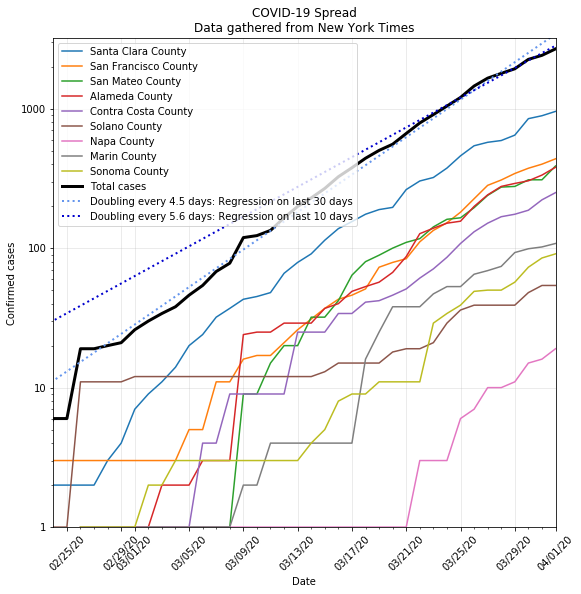

In [3]:
   
baycounties = ["Santa Clara", "San Francisco", "San Mateo", "Alameda", "Contra Costa", "Solano", "Napa", "Marin", "Sonoma"]
loglogplot(baycounties)

# Comparing metropolitan areas

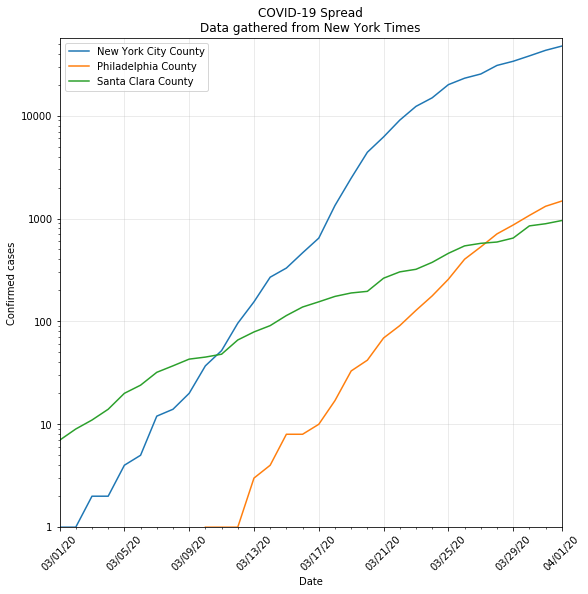

In [5]:
countydata[countydata["state"]=="New York"]["county"].value_counts()
loglogplot(["New York City", "Philadelphia", "Santa Clara"],totals=False)

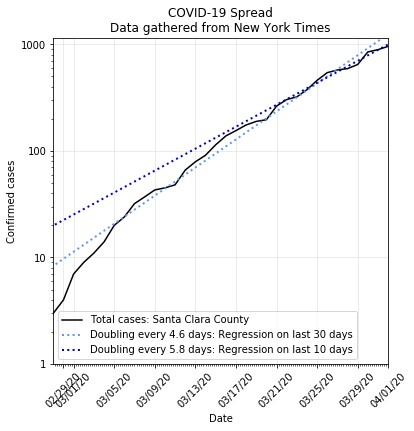

In [6]:
loglogplot(["Santa Clara"])